In [ ]:
import pandas as pd
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import train_test_split


# getting the dataset from files
train_df = pd.read_csv('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Toxic_dataset/toxic_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Toxic_dataset/toxic_test.csv')

#Merging datasets
df = pd.concat([train_df,test_df ])
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
63973,":Jerome, I see you never got around to this…! ...",0
63974,==Lucky bastard== \r\n http://wikimediafoundat...,0
63975,==shame on you all!!!== \r\n\r\n You want to s...,0
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1


In [ ]:
# Balancing data 
df_toxic  = df[df['toxic']==1]
df_non_toxic = df[df['toxic']==0]

lenght = len(df_toxic)

df_balanced = pd.concat([df_toxic, df_non_toxic.iloc[:lenght]]).sample(frac=1)

In [ ]:
# number of values of the toxic column (target)
X = df_balanced['comment_text']
X = X.to_list()
y = df_balanced['toxic']

In [ ]:
y

6         1
12        1
16        1
42        1
43        1
         ..
126961    0
36105     0
35963     0
20875     0
124688    0
Name: toxic, Length: 42768, dtype: int64

## Preprocessing

### Creating a transformer for preprocessing text data

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin # a transformer enherits these classes

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

import re

# transformer class
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords, stemmer):
        super().__init__()
        self.stopwords = stopwords
        self.stemmer = stemmer
        self.hapaxes = []
        self.named_entities = []
    
    # by default a transformer's fit method just returns self
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # for every text in the X list transform its data
        for i, sample in enumerate(X):
            X[i] = self.__normalize(sample)
            X[i] = self.__eliminate_stopwords(X[i])
            X[i] = self.__get_hapaxes(X[i])
            X[i] = self.__stem(X[i])
            self.__named_entity_extraction(X[i])
        
        # return the transformed text list
        return X

    def __normalize(self, text):
        # select only the words, make them lowercase and eliminate \r and \n
        return ' '.join(re.findall('[a-zA-Z]+', text.lower().replace(r'\r', ' ').replace(r'\n', ' ')))
    
    def __eliminate_stopwords(self, text):
        if self.stopwords is not None:
            return ''.join([word for word in text if word not in self.stopwords])
    
    def __get_hapaxes(self, text, eliminate=True):
        # getting the hapaxes
        fd = FreqDist(word_tokenize(text))
        self.hapaxes.append(fd.hapaxes())
                       
        # eliminating the hapaxes if needed (by default: needed)
        if eliminate:
            text = ''.join([word for word in text if word not in self.hapaxes])
        
        return text
    
    def __stem(self, text):
        return ' '.join([self.stemmer.stem(word) for word in word_tokenize(text)])
    
    def __named_entity_extraction(self, text):
        # tokenize text's sentences
        for sent in sent_tokenize(text):
            # get the part-of-speech tags of every token of the current sentence
            for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sent))):
                # store named entities
                if hasattr(chunk, 'label'):
                    self.named_entities.append(chunk)

### Using the transformer to preprocess the training text

In [ ]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
stopwords = stopwords.words('english')

# create an instance of the transformer class

transformer = TextTransformer(stopwords=['and', 'for', 'in', 'about', 'for', 'as', 'the'], stemmer=PorterStemmer())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
#Transform our data
X_train= transformer.transform(X_train[:10000])
X_test = transformer.transform(X_test[:3000])
y_train = y_train[:10000]
y_test = y_test[:3000]

## Choosing the model

The plan is to test the accuracy of different models on the same dataset.

In [ ]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler


### Logistic Regression

0.8676666666666667


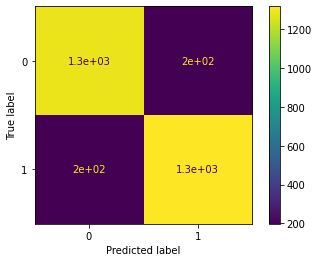

In [ ]:
from sklearn.linear_model import LogisticRegression

# creating a pipeline for Logistic Regression
lr_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe.fit(X_train, y_train) # fitting the model
print(accuracy_score(y_test, lr_pipe.predict(X_test)))

plot_confusion_matrix(lr_pipe, X_test, y_test)

### NB models

Complement Naive Bayes
0.8676666666666667
Bernoulli Naive Bayes
0.8676666666666667
Multinomial Naive Bayes
0.8676666666666667


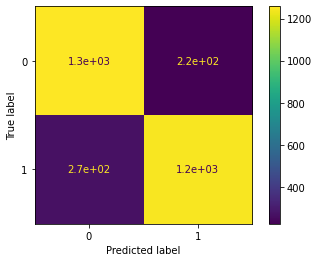

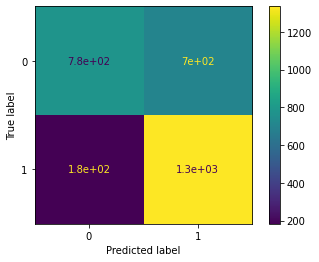

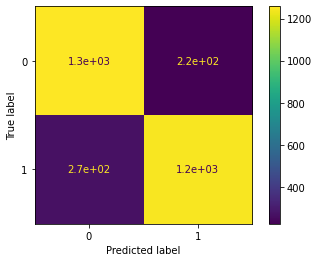

In [ ]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB

cnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    ComplementNB()
)

bnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    BernoulliNB()
)

mnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    MultinomialNB()
)

# fitting the models
cnb_pipe.fit(X_train, y_train)
print('Complement Naive Bayes')
print(accuracy_score(y_test, lr_pipe.predict(X_test)))
plot_confusion_matrix(cnb_pipe, X_test, y_test)

bnb_pipe.fit(X_train, y_train)
print('Bernoulli Naive Bayes')
print(accuracy_score(y_test, lr_pipe.predict(X_test)))
plot_confusion_matrix(bnb_pipe, X_test, y_test)

mnb_pipe.fit(X_train, y_train)
print('Multinomial Naive Bayes')
print(accuracy_score(y_test, lr_pipe.predict(X_test)))
plot_confusion_matrix(mnb_pipe, X_test, y_test)

### Decision Tree

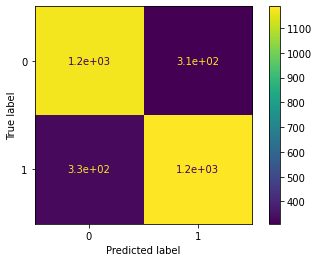

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    DecisionTreeClassifier(class_weight='balanced')
)

dt_pipe.fit(X_train, y_train)
plot_confusion_matrix(dt_pipe, X_test, y_test)

### K-nearest neighbors

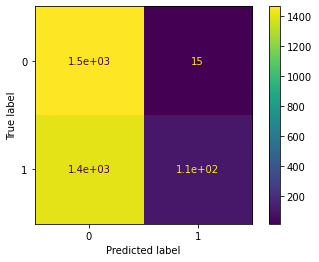

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    KNeighborsClassifier()
)

kn_pipe.fit(X_train, y_train)
plot_confusion_matrix(kn_pipe, X_test, y_test)

### Perceptron

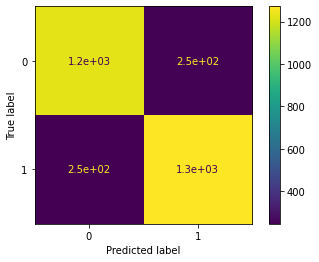

In [ ]:
from sklearn.linear_model import Perceptron

p_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    Perceptron()
)

p_pipe.fit(X_train, y_train)
plot_confusion_matrix(p_pipe, X_test, y_test)

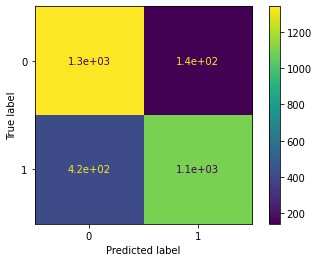

In [ ]:
from sklearn.svm import SVC

svm_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    SVC()
)

svm_pipe.fit(X_train, y_train)
plot_confusion_matrix(svm_pipe, X_test, y_test)

### Support Vector Machine




## Comparing accuracy scores

In [ ]:
# getting the accuracy scores for every model
scores = {
    'Logistic Regression': [accuracy_score(y_test, lr_pipe.predict(X_test))],
    'Complement NB': [accuracy_score(y_test, cnb_pipe.predict(X_test))],
    'Bernoulli NB': [accuracy_score(y_test, bnb_pipe.predict(X_test))],
    'Multinomail Regression': [accuracy_score(y_test, mnb_pipe.predict(X_test))],
    'Decision Tree': [accuracy_score(y_test, dt_pipe.predict(X_test))],
    'K-nearest neighbors': [accuracy_score(y_test, kn_pipe.predict(X_test))],
    'Perceptron': [accuracy_score(y_test, p_pipe.predict(X_test))],
    'SVM': [accuracy_score(y_test, svm_pipe.predict(X_test))]
}

# creating a DataFrame from the scores dictionary
scores_df = pd.DataFrame.from_dict(scores)
scores_df

,Logistic Regression,Complement NB,Bernoulli NB,Multinomail Regression,Decision Tree,K-nearest neighbors,Perceptron,SVM
0,0.867667,0.835667,0.704333,0.835667,0.786333,0.525667,0.834333,0.812333


In [ ]:
# finding the best accuracy
model_name = scores_df.idxmax(axis=1)[0]
f'{model_name} : {scores_df[model_name][0]}'

'Logistic Regression : 0.8676666666666667'

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_pipe.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1482
           1       0.87      0.87      0.87      1518

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [ ]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lr_pipe.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lr_pipe.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lr_pipe.predict(X_test))))

Mean Absolute Error: 0.13233333333333333
Mean Squared Error: 0.13233333333333333
Root Mean Squared Error: 0.36377648815355473
